## CLASSIFICATION of SPEECH FRAMES

### PART IV:  Recognize Vowels from FBANK features using DNN Classifiers in PyTorch

### 1. Setting up your Python Environment
 
+ Import Python's Machine Learning Stack
+ Import needed local utilities that are needed for this exercise
+ Import Pytorch

In [1]:
%matplotlib inline
import io, os, sys
import logging
import urllib.request

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.io as sio
import seaborn as sns
import torch
from scipy.fftpack import dct

# pyspch
try:
  import google.colab
  IN_COLAB = True
  ! pip install git+https://github.com/compi1234/pyspch.git@v0.6
except:
  IN_COLAB = False

import pyspch
import pyspch.nn

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)

# logging (see pyspch.nn.train())
logging.basicConfig(level=logging.WARNING)


In [2]:
# choose the colors you like :)
palette = sns.color_palette("bright")
# palette=['red','green','blue','orange','brown','black','dodgerblue','mediumturquoise','cyan','violet','gold','salmon'] 
# sns.palplot(palette)
sns.set_palette(palette)

### 2. The Database 
The experiments in this notebook use a subset of the TIMIT database.
Instead of using raw speech, we extract features from the speech signal.
In what follows we will asses how 
There is FILTERBANK data from 3 vowels (i,a,uw) , 400 samples for training and 200 samples for testing.
The data is 24-dimensional (24 channels in the filterbank).
http://homes.esat.kuleuven.be/~spchlab/datasets/tinytimit/README.txt

The loaded data consists of:
- data matrices   FBANK_train(2400,3), FBANK_test(600,3)
- labels          y_train(2400,), y_test(600,)

In [3]:
# loads all data in a matlab file at given url to the contents structure
# this is working for MATLAB 7.0 files and older ; not hdf5 MATLAB 7.3 or more recent
def load_matlab_from_url(url):
    url_response = urllib.request.urlopen(url)
    matio = io.BytesIO(url_response.read())
    contents = sio.loadmat(matio,squeeze_me=True)
    return(contents)

# we will import 400 train samples and 200 test samples for 3 vowels
tinytimit = 'http://homes.esat.kuleuven.be/~spchlab/data_old/tinytimit/'
url_mf = tinytimit + 'male-female.mat' 
data_mf = load_matlab_from_url(url_mf)
url_vow3= tinytimit + 'a-i-uw-800.mat' 
data_vow3 = load_matlab_from_url(url_vow3)

# labels
y_train =np.full((2400,),'a',dtype='<U2')
y_train[800:1600] =np.full((800,),'i',dtype='<U2')
y_train[1600:2400] =np.full((800,),'uw',dtype='<U2')
y_test =np.full((600,),'a',dtype='<U2')
y_test[200:400] =np.full((200,),'i',dtype='<U2')
y_test[400:600] =np.full((200,),'uw',dtype='<U2')
classes = np.unique(y_train)

# load_data('tinytimit')
#   data = (X_train, X_test, y_train, y_test)

In [4]:
(FB_train, FB_test, y_train, y_test) = pyspch.core.load_data('tinytimit')
classes = np.unique(y_train)

#### Feature Extraction

For our NN-based phoneme-classifier, we can choose between three types of input features.  First, we have the filterbank energies (FBANK) directly. Second, we can use the PCA features derrived from the FBANK features. Alternatively MFCC features can be derived from the FBANK features.

In [5]:
# A. Filterbank Energies (spectral features)
#FB_train=data_vow3['ALLtrain'].T
#FB_test=data_vow3['ALLtest'].T

# B. PCA features (Principle Component Analysis)
from sklearn.decomposition import PCA
pca = PCA()
T = pca.fit(FB_train)
PCA_train = T.transform(FB_train)
PCA_test = T.transform(FB_test)

# C. Mel-Frequency Cepstral Coefficients
MFCC_train = dct(FB_train, type=2, axis=1, norm='ortho')
MFCC_test = dct(FB_test, type=2, axis=1, norm='ortho')

#### Feature visualization

In [6]:
# Define a number of different Features

# A. Filterbank Energies (spectral features)
dfX = pd.DataFrame(FB_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
FB_df = pd.concat([dfy, dfX], axis=1)

# B. PCA features (Principle Component Analysis)
dfX = pd.DataFrame(PCA_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
PCA_df = pd.concat([dfy, dfX], axis=1)

# C. Mel-Frequency Cepstral Coefficients
dfX = pd.DataFrame(MFCC_train[:,0:4])
dfy = pd.Series(y_train, name='vowel')
MFCC_df = pd.concat([dfy, dfX], axis=1)

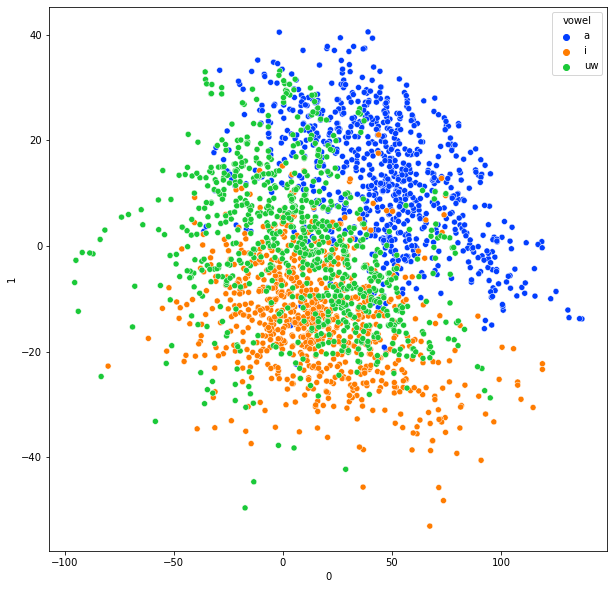

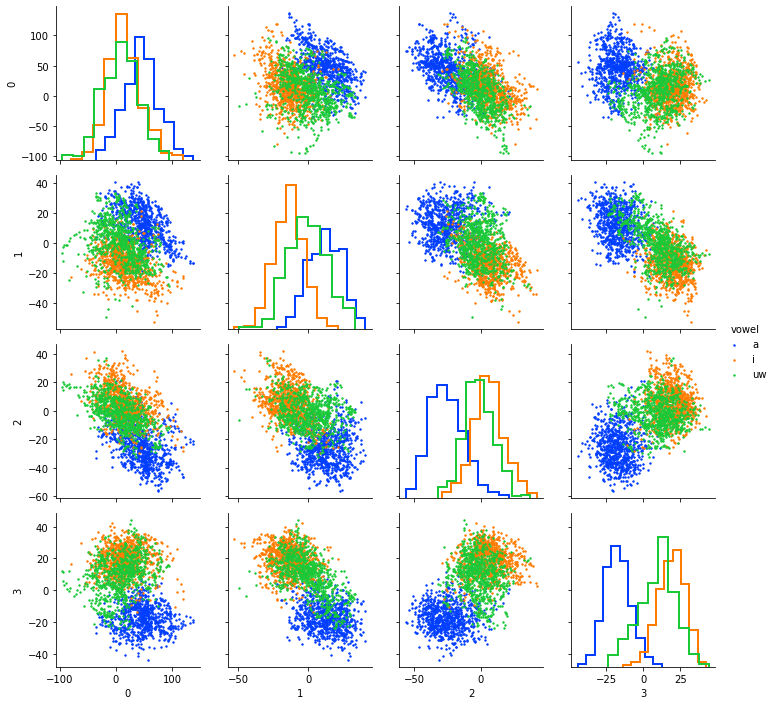

In [7]:
# choose feature set to use in plots and experiments
df = MFCC_df
df.columns = ["vowel","0","1","2","3"]

doPlot = True
if doPlot:
  # plot 2 first dimensions of feature 
  f=plt.figure(figsize=(10, 10))
  sns.scatterplot(data=df, x="0", y="1", hue='vowel')

  # plot all dimensions pairwise
  g = sns.PairGrid(df, hue="vowel")
  g.map_diag(plt.hist, histtype="step", linewidth=2)
  g.map_offdiag(plt.scatter, s=2)
  g.add_legend()

### 3. Setting up a Neural Network in Pytorch

Quite a few helper routines are defined for learning our Neural Network in Pytorch.
There is no need to go through this in detail, but interested people can of course do this.

There are 3 blocks of code:
- definition of classes for the Neural Net and the Data Sets
- training routines
- evalutation routines

In [8]:
# =============================================================================
# Define Classes for Neural network architecture and Data Sets
# =============================================================================

# simple feedforward neural network 
class simple_ffnn(torch.nn.Module):
    
    def __init__(self, in_dim, out_dim, hidden_layer_sizes):
        super(simple_ffnn, self).__init__()

        # attributes
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hidden_layer_sizes = hidden_layer_sizes

        # parameters
        layer_sizes = (in_dim, *hidden_layer_sizes, out_dim)
        layer_sizes_pairwise = [(layer_sizes[i], layer_sizes[i+1]) for 
                                 i in range(len(layer_sizes)-1)]

        # define architecture
        modulelist = torch.nn.ModuleList([])
        for layer_in_size, layer_out_size in layer_sizes_pairwise:
            modulelist.append(torch.nn.Linear(layer_in_size, layer_out_size))
            modulelist.append(torch.nn.Sigmoid())

        # define network as nn.Sequential
        self.net = torch.nn.Sequential(*modulelist)

    def forward(self, x):
        x = self.net(x)
        return x
        
    def init_weights(self):
        self.net.apply(init_normal) 

# weight initialization
def init_normal(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.kaiming_uniform_(m.weight)   
        
# Dataset 
class SimpleDataset(torch.utils.data.Dataset):
    """Simple dataset for easy sampling."""

    def __init__(self, data_X, data_y, labels, labeldict, device):

        # dimensionality
        self.n_samples, self.n_features = data_X.shape
        self.n_classes = len(labels)

        # input data
        self.frames = data_X # (n_samples, n_features)
        self.frames = torch.as_tensor(self.frames, dtype=torch.float32).to(device)

        # labels
        if data_y.dtype != "int64":
            data_y = np.vectorize(labeldict.get)(data_y)
        self.labels = torch.as_tensor(data_y, dtype=torch.long).to(device)

    def split(self, frac=None, seed=None):
        if frac is None:
            return None, self
        else:
            n_split = int(len(self) * frac)
            if seed is not None: torch.manual_seed(seed)
            return torch.utils.data.random_split(self, [n_split, len(self) - n_split])
    

    def __len__(self):
        
        return self.n_samples

    def __getitem__(self, idx):
        frame = self.frames[idx] 
        label = self.labels[idx]
        
        return frame, label

### 4. Experimental setup

- Choose the feature extraction
- Define Network Architecture

In [9]:
# Features (X) and labels (y) used for experiment

# input data
train_X = MFCC_train
test_X = MFCC_test

# define One-Hot Encoding for labels
labels = ["a", "i", "uw"]
labeldict = {"a" : 0, "i" : 1, "uw" : 2} 
inv_labeldict = {v : k for k, v in labeldict.items()}

# encode labels
train_y = np.vectorize(labeldict.get)(y_train).astype(np.int64)
test_y = np.vectorize(labeldict.get)(y_test).astype(np.int64)

In [10]:
# network dimensions
in_dim = train_X.shape[1]
out_dim = len(classes)
hidden_layer_sizes = [512,512]

# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
# Dataset and Dataloader for easy sampling mini-batches

# construct dataset
train_ds = SimpleDataset(train_X, train_y, labels, labeldict, device)
test_ds = SimpleDataset(test_X, test_y, labels, labeldict, device)

# construct dataloader
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256)

### Gradient descent: batch vs. mini-batch vs mini-batch with early stopping

We created a test setup in which 4 settings are compared: 2 are batch, one is mini-batch and the last is mini-batch with early stopping

A few things to investigate:
- full batch training converges slower than mini-batch training: you can change the number of epochs, change number of epochs to see how 'cross entropy loss converges'
- cross entropy loss is a good training criterion, but you may observe that 'full convergence' on the optimization criterion (CE) is not the same as 'full convergence' on error rate on independent test set; again change n_epochs to evaluate this

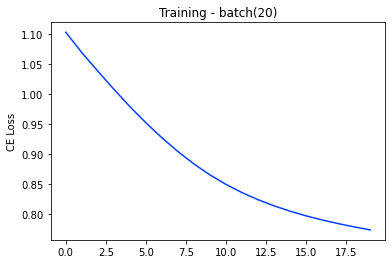

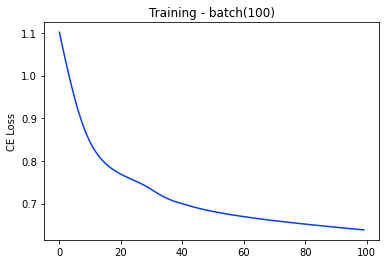

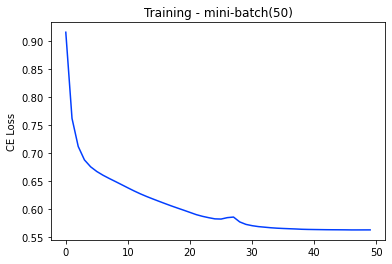

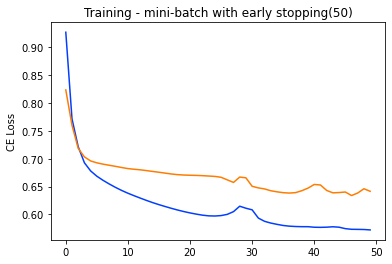

In [12]:
# general training setup
# n_epochs = 10
lr = 0.001
print_every = 1
seed = 1234

criterion = torch.nn.CrossEntropyLoss() # loss function [applies softmax()]
clip_args = None # gradient clipping
scheduler = None # learning rate scheduler

# variations
n_epochs = [20,100, 50, 50]
batch_sizes = [2400, 2400, 128, 128] # 2400 = full batch
patiences = [float('inf'), float('inf'), float('inf'), 20]
val_fracs = [0, 0, 0, 0.1]
names = ['batch', 'batch', 'mini-batch', 'mini-batch with early stopping']

models = []
train_dicts = []
eval_dicts = []

for n_epoch, batch_size, patience, val_frac, name in zip(n_epochs, batch_sizes, patiences, val_fracs, names):
    
    # initialize model & optimizer
    current_epoch = 0
    model = simple_ffnn(in_dim=in_dim, out_dim=out_dim, hidden_layer_sizes=hidden_layer_sizes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # ties model-parameters to optimizer (back-propagation)

    # dataset and validation split
    train_ds = SimpleDataset(train_X, train_y, labels, labeldict, device)
    valid_ds, train_ds = train_ds.split(val_frac, seed)
    
    # dataloaders 
    train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
    if valid_ds: valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size)
    else: valid_dl = None
    
    # train
    train_loss, val_loss, end_epoch = pyspch.nn.train(model, train_dl, 
        criterion, optimizer, 
        clip_args, scheduler,
        current_epoch, n_epoch, 
        valid_dl, patience, print_every)
    
    # plot training loss
    plt.figure()
    plt.plot(train_loss)
    if valid_ds: plt.plot(val_loss)
    plt.title("Training - " + name + '('+ str(n_epoch)+')')
    plt.ylabel("CE Loss")
    
    # save training
    models.append(model)
    train_dicts.append({'train': train_loss, 'val': val_loss, 'epoch': end_epoch})


BATCH
PER 0.21 and PER per phone class [0.02  0.145 0.47 ]
CE Loss 0.81


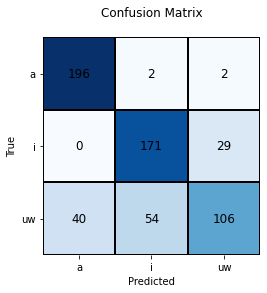

BATCH
PER 0.16 and PER per phone class [0.02 0.11 0.34]
CE Loss 0.75


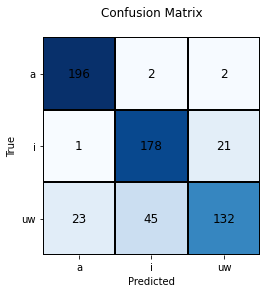

MINI-BATCH
PER 0.15 and PER per phone class [0.015 0.16  0.285]
CE Loss 0.73


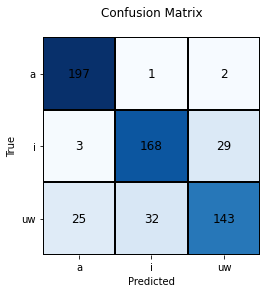

MINI-BATCH WITH EARLY STOPPING
PER 0.15 and PER per phone class [0.015 0.13  0.3  ]
CE Loss 0.73


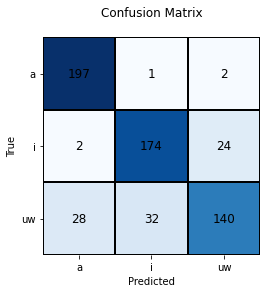

In [13]:
for model, name in zip(models, names):
    
    print(name.upper())
    
    # Confusion matrix
    cm = pyspch.nn.evaluate_cm(model, test_dl) 

    # Phone Error Rate (PER) + PER per phone class
    per, per_pc = pyspch.nn.cm2per(cm)
    print("PER %.2f and PER per phone class %s" % (per, np.round(per_pc, 4)))

    # Cross-entropy loss
    print("CE Loss %.2f" % pyspch.nn.evaluate(model, test_dl, criterion))

    # plot
    pyspch.plot_confusion_matrix(cm, classes)
    